<a href="https://colab.research.google.com/github/oktaw-g/AI/blob/main/P5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Wczytanie danych z biblioteki TorchVision

Zmiana normalize na znaleziony w internecie
Wycięcie środka ze zdjęć, stracono po 2 piksele na bokach, więc można pominąć, wczytujemy CIFAR10

In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader


# transformacje dla pre-processingu
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        #transforms.Resize((28,28))
        #transforms.CenterCrop(28)
    ]
)

# FashionMNIST dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Data loader
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:05<00:00, 30.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#EDA

zmiana labeli, nie wiem jak działa tutaj imshow, to bez zmian, grunt, że wyświetla

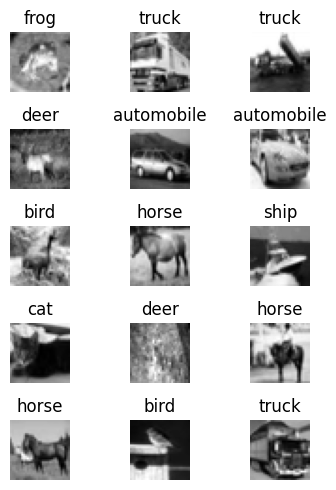

In [2]:
from matplotlib import pyplot as plt
LABELS = {
  0: "airplane",
  1: "automobile",
  2: "bird",
  3: "cat",
  4: "deer",
  5: "dog",
  6: "frog",
  7: "horse",
  8: "ship",
  9: "truck"
}

fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(4, 5))
axes = axes.flatten()

for i,(img, label) in enumerate(train_dataset):
  if i >= 15: break

  axes[i].imshow(img[0, :, :], cmap="gray")
  axes[i].axis("off")
  axes[i].set_title(LABELS[label])

plt.tight_layout()
plt.show()

#Definiowane dwóch modeli konwolucyjnych

In [13]:
# WŁASNA SIEĆ NEURONOWA


import torch
import torch.nn as nn
import torch.nn.functional as F


class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)  # 32x32 -> 30x30
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3) # 30x30 -> 28x28
        # Pooling layer
        self.pool = nn.AvgPool2d(2, 2)  # Pooling: 28x28 -> 14x14 -> 12x12 -> 6x6
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 6 * 6, 128)  # Adjusted for the output size
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 -> 30x30 -> 15x15
        x = self.pool(F.relu(self.conv2(x)))  # 15x15 -> 13x13 -> 6x6
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model_custom = CustomCNN()

In [25]:
# RESNET18

from torchvision.models import resnet18, ResNet18_Weights

# Load pre-trained ResNet18
model_resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify the first convolutional layer for 32x32 input
model_resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)



# Print the modified model for verification
print(model_resnet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
print(f"Custom model: {sum(p.numel() for p in model_custom.parameters() if p.requires_grad)} trenowalnych parametrów")

Custom model: 84154 trenowalnych parametrów


In [26]:
print(f"ResNet18: {sum(p.numel() for p in model_resnet.parameters() if p.requires_grad)} trenowalnych parametrów")

ResNet18: 11681832 trenowalnych parametrów


In [7]:
!pip install torchview
from torchview import draw_graph

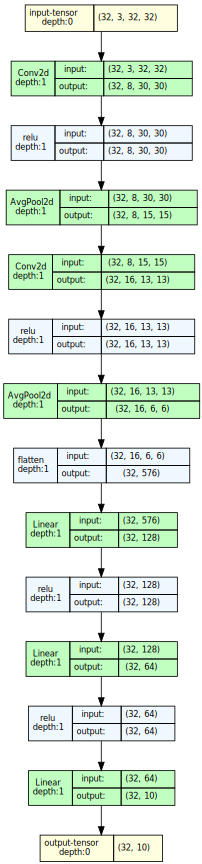

In [8]:
model_visualizer = draw_graph(model_custom, input_size=(batch_size, 3, 32, 32)) # input_size=(batch_size, 1, 28, 28) - rozmiar wejściowy (B, C, H, W)
# na 3 channele, bo kolory, rozmiar zdjęć zjechaliśmy z 32 na 28 więc zostawiamy
model_visualizer.visual_graph

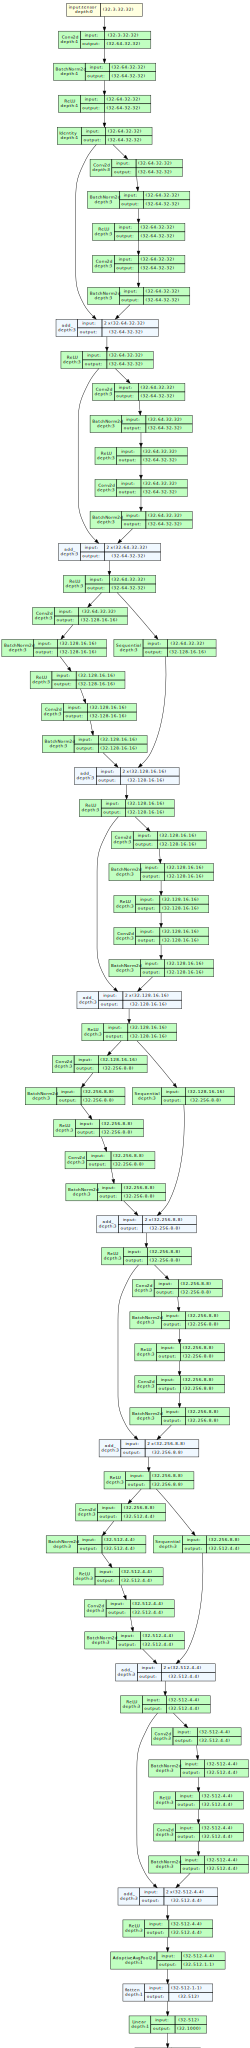

In [18]:
model_visualizer = draw_graph(model_resnet, input_size=(batch_size, 3, 32, 32)) # input_size=(batch_size, 1, 28, 28) - rozmiar wejściowy (B, C, H, W), to samo co wyżej
model_visualizer.visual_graph

#Trenowanie modeli

In [21]:
def plot_loss(train_loss, val_loss, val_accuracy, save_name):

    fig, axes = plt.subplots(ncols=2, figsize=(8, 4))


    axes[0].plot(val_loss, marker='.', label='Validation')
    axes[0].plot(train_loss, marker='.', label='Train')
    axes[1].plot(val_accuracy, marker='.', label='Validation')

    axes[0].legend()
    axes[1].legend()

    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")

    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")

    fig.tight_layout()
    fig.show()

    fig.savefig(save_name, dpi=300, bbox_inches='tight')

In [22]:
from torch import optim
from tqdm import tqdm

def train(model, save_name, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(epochs):

        model.train()
        losses = []

        for i, (inputs, labels) in tqdm(enumerate(train_dataloader, 0),desc=f"[{epoch + 1}/{epochs}] Training"):

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        train_loss.append(np.mean(losses))

        # validation loss
        model.eval()
        losses = []
        correct_preds = 0

        for i, (inputs, labels) in tqdm(enumerate(test_dataloader),desc=f"[{epoch + 1}/{epochs}] Validation"):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            correct_preds += (outputs.argmax(dim=1) == labels).float().mean().item()

        val_accuracy.append(correct_preds/len(test_dataloader))
        val_loss.append(np.mean(losses))

        # print loss
        print(f'\ttrain loss: {train_loss[-1]:.4f} | val loss: {val_loss[-1]:.4f}| val acc.: {val_accuracy[-1]*100.0:.2f}\n')

    torch.save(model.state_dict(), save_name)

    return train_loss, val_loss, val_accuracy

In [14]:
train_loss, val_loss, val_accuracy = train(model_custom, 'model_custom.pth', epochs=10)

[1/10] Training: 1563it [00:27, 56.22it/s]
[1/10] Validation: 313it [00:03, 87.11it/s]


	train loss: 1.6221 | val loss: 1.3933| val acc.: 49.37



[2/10] Training: 1563it [00:28, 54.54it/s]
[2/10] Validation: 313it [00:04, 76.20it/s]


	train loss: 1.3360 | val loss: 1.2820| val acc.: 53.50



[3/10] Training: 1563it [00:28, 55.26it/s]
[3/10] Validation: 313it [00:03, 92.89it/s]


	train loss: 1.2053 | val loss: 1.1921| val acc.: 57.86



[4/10] Training: 1563it [00:28, 55.71it/s]
[4/10] Validation: 313it [00:04, 73.61it/s]


	train loss: 1.1135 | val loss: 1.1553| val acc.: 59.42



[5/10] Training: 1563it [00:26, 59.20it/s]
[5/10] Validation: 313it [00:03, 93.48it/s]


	train loss: 1.0433 | val loss: 1.1164| val acc.: 60.34



[6/10] Training: 1563it [00:26, 58.40it/s]
[6/10] Validation: 313it [00:03, 91.92it/s]


	train loss: 0.9859 | val loss: 1.1020| val acc.: 61.24



[7/10] Training: 1563it [00:27, 56.48it/s]
[7/10] Validation: 313it [00:03, 84.30it/s]


	train loss: 0.9325 | val loss: 1.0429| val acc.: 63.84



[8/10] Training: 1563it [00:26, 58.20it/s]
[8/10] Validation: 313it [00:03, 91.23it/s]


	train loss: 0.8917 | val loss: 1.0592| val acc.: 63.81



[9/10] Training: 1563it [00:26, 58.94it/s]
[9/10] Validation: 313it [00:04, 74.94it/s]


	train loss: 0.8459 | val loss: 1.0234| val acc.: 64.18



[10/10] Training: 1563it [00:27, 57.23it/s]
[10/10] Validation: 313it [00:03, 92.51it/s]

	train loss: 0.8102 | val loss: 1.0218| val acc.: 64.64



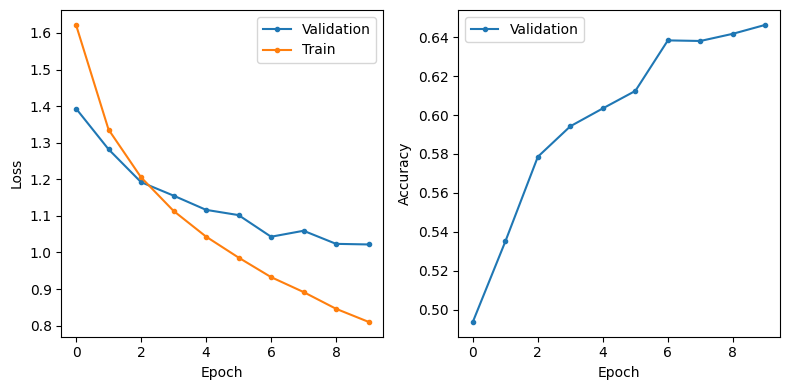

In [15]:
plot_loss(train_loss, val_loss, val_accuracy, 'model_custom.png')

**Resnet**

In [27]:
train_loss, val_loss, val_accuracy = train(model_resnet, 'model_resnet.pth', epochs=10)

[1/10] Training: 1563it [14:39,  1.78it/s]
[1/10] Validation: 313it [00:45,  6.91it/s]


	train loss: 1.1581 | val loss: 0.8644| val acc.: 72.12



[2/10] Training: 1563it [14:57,  1.74it/s]
[2/10] Validation: 313it [00:47,  6.53it/s]


	train loss: 0.6997 | val loss: 0.6867| val acc.: 76.55



[3/10] Training: 1563it [14:42,  1.77it/s]
[3/10] Validation: 313it [00:46,  6.70it/s]


	train loss: 0.5496 | val loss: 0.5634| val acc.: 80.87



[4/10] Training: 1563it [14:55,  1.75it/s]
[4/10] Validation: 313it [00:45,  6.93it/s]


	train loss: 0.4260 | val loss: 0.5546| val acc.: 81.08



[5/10] Training: 1563it [13:44,  1.90it/s]
[5/10] Validation: 313it [00:46,  6.76it/s]


	train loss: 0.3263 | val loss: 0.5811| val acc.: 81.09



[6/10] Training: 1563it [14:40,  1.78it/s]
[6/10] Validation: 313it [00:44,  6.98it/s]


	train loss: 0.2530 | val loss: 0.6130| val acc.: 82.66



[7/10] Training: 1563it [14:42,  1.77it/s]
[7/10] Validation: 313it [00:46,  6.69it/s]


	train loss: 0.1825 | val loss: 0.6490| val acc.: 81.81



[8/10] Training: 1563it [15:02,  1.73it/s]
[8/10] Validation: 313it [00:46,  6.75it/s]


	train loss: 0.1596 | val loss: 0.5720| val acc.: 83.60



[9/10] Training: 1563it [14:50,  1.76it/s]
[9/10] Validation: 313it [00:45,  6.81it/s]


	train loss: 0.1289 | val loss: 0.6731| val acc.: 82.44



[10/10] Training: 1563it [15:07,  1.72it/s]
[10/10] Validation: 313it [00:45,  6.81it/s]

	train loss: 0.1087 | val loss: 0.6551| val acc.: 83.21



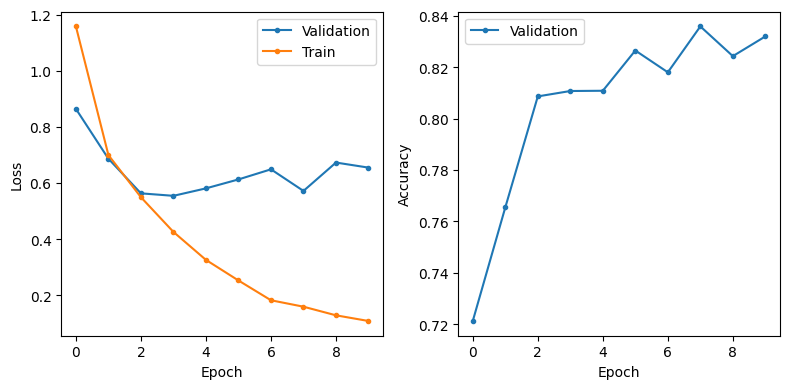

In [28]:
plot_loss(train_loss, val_loss, val_accuracy, 'model_resnet.png')

In [ ]:
del model_custom, model_resnet

#Walidacja

In [29]:
# 1.6. Czytanie modelu

model_custom = CustomCNN()
model_resnet = resnet18()
model_resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

model_custom.load_state_dict(torch.load("model_custom.pth", weights_only=True))
model_resnet.load_state_dict(torch.load("model_resnet.pth", weights_only=True))

<All keys matched successfully>

In [30]:
# Prosta ewaluacja - ACCURACY / DOKŁADNOŚĆ modelu (globalna)

def evaluate(model):
    correct_preds = 0

    model.eval()
    with torch.no_grad():
        for images, labels in test_dataloader:
            correct_preds += (model(images).argmax(dim=1) == labels).float().mean().item()

    accuracy = correct_preds * 100 / len(test_dataloader)

    print(f'Global accuracy on test set: {accuracy:.2f}%')

In [31]:
print("Custom model:")
evaluate(model_custom)

Custom model:
Global accuracy on test set: 64.64%


**Resnet**

In [32]:
print("ResNet18:")
evaluate(model_resnet)

ResNet18:
Global accuracy on test set: 83.21%


In [33]:
# Confusion matrix / macierz pomyłek
# Jak model radzi sobie z poszczególnymi klasami

def confusion_matrix(model, n_classes=10):
    matrix = np.zeros((n_classes, n_classes),dtype=int)

    model.eval()
    with torch.no_grad():
        for images, labels in test_dataloader:

            predicted = torch.max(model(images).data, 1)[1]

            for p,l in zip(predicted, labels):
                p,l = p.item(), l.item()
                matrix[p,l] += 1

    return matrix

In [34]:
matrix_custom = confusion_matrix(model_custom)

**Resnet**

In [35]:
matrix_resnet = confusion_matrix(model_resnet)

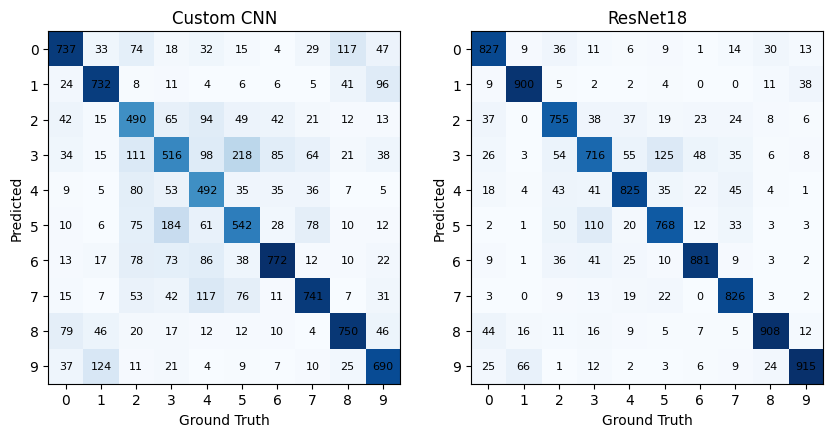

In [36]:
fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(matrix_custom, cmap='Blues')
ax[0].set_title("Custom CNN")
ax[0].set_xticks(list(LABELS.keys()))
ax[0].set_yticks(list(LABELS.keys()))

ax[0].set_ylabel("Predicted")
ax[0].set_xlabel("Ground Truth")

for i in range(10):
    for j in range(10):
        ax[0].text(j, i, matrix_custom[i, j], ha="center", va="center", color="black", fontsize=8)


ax[1].imshow(matrix_resnet, cmap='Blues')
ax[1].set_title("ResNet18")
ax[1].set_xticks(list(LABELS.keys()))
ax[1].set_yticks(list(LABELS.keys()))

ax[1].set_ylabel("Predicted")
ax[1].set_xlabel("Ground Truth")

for i in range(10):
    for j in range(10):
        ax[1].text(j, i, matrix_resnet[i, j], ha="center", va="center", color="black", fontsize=8)

plt.show()

In [37]:
# Analiza macierzy pomyłek
# Wyznaczenie metryk dla poszczególnych klas
# Wyznaczenie metryk globalnych - uśrednienie po klasach

def analyze_matrix(matrix):
    global_res = {"accuracy": np.zeros(matrix.shape[0]), "precision": np.zeros(matrix.shape[0]), "recall": np.zeros(matrix.shape[0]), "f1": np.zeros(matrix.shape[0])}
    for i,c in LABELS.items():
        print(f'{c}:')
        tp = matrix[i,i]
        fp = np.sum(matrix[i,:]) - tp
        fn = np.sum(matrix[:,i]) - tp
        tn = np.sum(matrix) - tp - fp - fn

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)
        accuracy = (tp+tn) / (tp+fp+fn+tn)

        global_res["accuracy"][i] = accuracy
        global_res["precision"][i] = precision
        global_res["recall"][i] = recall
        global_res["f1"][i] = f1

        print(f'\taccuracy: {accuracy*100.0:.2f}, precision: {precision*100.0:.2f}, recall: {recall*100.0:.2f}, F1: {f1*100.0:.2f}')

    print(f'-------------\nGlobal (macro) results:')
    print(f'\taccuracy: {np.mean(global_res["accuracy"])*100.0:.2f}, precision: {np.mean(global_res["precision"])*100.0:.2f}, recall: {np.mean(global_res["recall"])*100.0:.2f}, F1: {np.mean(global_res["f1"])*100.0:.2f}')

In [38]:
analyze_matrix(matrix_custom)

airplane:
	accuracy: 93.68, precision: 66.64, recall: 73.70, F1: 69.99
automobile:
	accuracy: 95.31, precision: 78.46, recall: 73.20, F1: 75.74
bird:
	accuracy: 91.37, precision: 58.13, recall: 49.00, F1: 53.17
cat:
	accuracy: 88.32, precision: 43.00, recall: 51.60, F1: 46.91
deer:
	accuracy: 92.27, precision: 64.99, recall: 49.20, F1: 56.00
dog:
	accuracy: 90.78, precision: 53.88, recall: 54.20, F1: 54.04
frog:
	accuracy: 94.23, precision: 68.87, recall: 77.20, F1: 72.80
horse:
	accuracy: 93.82, precision: 67.36, recall: 74.10, F1: 70.57
ship:
	accuracy: 95.04, precision: 75.30, recall: 75.00, F1: 75.15
truck:
	accuracy: 94.42, precision: 73.56, recall: 69.00, F1: 71.21
-------------
Global (macro) results:
	accuracy: 92.92, precision: 65.02, recall: 64.62, F1: 64.56


**Resnet**

In [39]:
analyze_matrix(matrix_resnet)

airplane:
	accuracy: 96.98, precision: 86.51, recall: 82.70, F1: 84.56
automobile:
	accuracy: 98.29, precision: 92.69, recall: 90.00, F1: 91.32
bird:
	accuracy: 95.63, precision: 79.73, recall: 75.50, F1: 77.56
cat:
	accuracy: 93.56, precision: 66.54, recall: 71.60, F1: 68.98
deer:
	accuracy: 96.12, precision: 79.48, recall: 82.50, F1: 80.96
dog:
	accuracy: 95.34, precision: 76.65, recall: 76.80, F1: 76.72
frog:
	accuracy: 97.45, precision: 86.63, recall: 88.10, F1: 87.36
horse:
	accuracy: 97.55, precision: 92.08, recall: 82.60, F1: 87.08
ship:
	accuracy: 97.83, precision: 87.90, recall: 90.80, F1: 89.33
truck:
	accuracy: 97.67, precision: 86.08, recall: 91.50, F1: 88.71
-------------
Global (macro) results:
	accuracy: 96.64, precision: 83.43, recall: 83.21, F1: 83.26
